In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

from collections import Counter
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
np.random.seed(12)
num_observations=5000

x1 = np.random.multivariate_normal([0,0],[[1,.75],[.75,1]], num_observations)
x2 = np.random.multivariate_normal([1,4],[[1,.75],[.75,1]], num_observations)

features = np.vstack((x1, x2)).astype(np.float32)
labels = np.hstack((np.full(num_observations, -1), np.ones(num_observations)))

In [3]:
print('Dataset Size : ',features.shape)
print('Labels Size : ',labels.shape)

Dataset Size :  (10000, 2)
Labels Size :  (10000,)


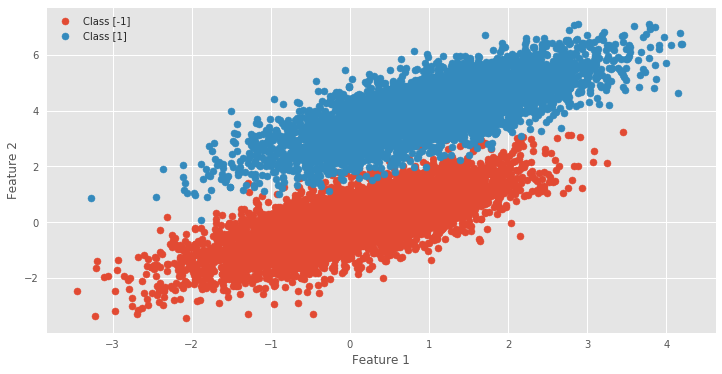

In [4]:
with plt.style.context(('seaborn','ggplot')):
    plt.figure(figsize=(12,6))
    plt.scatter(features[labels == -1, 0],features[labels == -1, 1], label='Class [-1]')
    plt.scatter(features[labels == 1, 0],features[labels == 1, 1], label='Class [1]')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(loc='best')

In [5]:
def generate_train_test_sets(features, labels):
    np.random.seed(123)
    x1 = np.arange(5000)
    np.random.shuffle(x1)
    x2 = np.arange(5000,10000)
    np.random.shuffle(x2)
    x = np.hstack((x1,x2))
    features_shuffled, labels_shuffled = features[x], labels[x]
    divider = int(0.8 * 5000)
    features_train_1 =features[:divider, :]
    features_train_2 =features[5000: 5000+divider, :]
    features_test_1 =features[divider:5000, :]
    features_test_2 =features[5000+divider: , :]
    
    labels_train_1 =labels[:divider]
    labels_train_2 =labels[5000: 5000+divider]
    labels_test_1 =labels[divider:5000]
    labels_test_2 =labels[5000+divider: ]
    
    train_features = np.vstack((features_train_1, features_train_2))
    test_features = np.vstack((features_test_1, features_test_2))
    
    train_labels = np.hstack((labels_train_1, labels_train_2))
    test_labels = np.hstack((labels_test_1, labels_test_2))
    
    return train_features, test_features, train_labels, test_labels

def sigmoid(features, weights, intercept=None):
    ''' 
    logistic(sigmoid) function 
    '''
    return 1.0/(1 + np.exp(-1* (np.dot(features, weights.T) + intercept))) if intercept else 1.0/(1 + np.exp(-np.dot(features, weights.T)))


def calculate_gradient(features, labels, weights, intercept=None): 
    ''' 
    logistic gradient function 
    weight_gradient = features * (preds - y)
    intercept_gradient = (preds - y)
    preds = sigmoid(features, weights, intercept)
    '''
    y_hat = sigmoid(features, weights, intercept)
    #sigmoid_minus_y = y_hat - labels.reshape(features.shape[0], -1) 
    sigmoid_minus_y = y_hat - labels
    weights_grad = np.dot(sigmoid_minus_y.T, features) 
    intercept_grad =  sigmoid_minus_y.mean()  if intercept else None
    return weights_grad, intercept_grad

def cost_function(features, labels, weights, intercept=None): 
    ''' 
    cost function, J = 1/n * (-y * log(1-y_hat) - (1-y) * log(1-y_hat))
    y_hat refers to prediction by model for that sample.
    y_hat = sigmoid(features, weights, intercept)
    '''
    y_hat = sigmoid(features, weights, intercept) 
    labels = np.squeeze(labels) 
    s1 = labels * np.log(y_hat) 
    s2 = (1 - labels) * np.log(1 - y_hat) 
    final = (-s1 - s2).mean()
    return final

def logistic_regression_PB(features, labels, num_steps, learning_rate, intercept_flag=True):
    weights = np.ones(features.shape[1]) * 0.1
    if intercept_flag:
        intercept = 0.1
    else:
        intercept = None
    cost = cost_function(features, labels, weights, intercept)
    change_cost = 1.0
    for i in range(1, num_steps+1):
        prev_cost = cost
        weights_grad, intercept_grad = calculate_gradient(features, labels, weights, intercept)
        #print(weights_grad.shape)
        #avg_wgts_gradient = np.mean(weights_grad, axis=0)
        weights -= learning_rate * weights_grad
        if intercept_flag:
            intercept -= learning_rate * intercept_grad
        cost = cost_function(features, labels, weights, intercept)
        change_cost = prev_cost - cost
        if i %1000 == 0:
            print('Cost & Weights after %d iterations.'%i)
            print(cost, weights, intercept)
        if change_cost < 0 or change_cost < 0.001:
            print('No change in cost. Breaking Loop after %d steps'%(i))
            break
            
    return weights, intercept

def pred_values(features, weights, intercept): 
    ''' 
    function to predict labels 
    '''
    pred_prob = sigmoid(features, weights, intercept) 
    pred_value = np.where(pred_prob >= .5, 1, -1) 
    return np.squeeze(pred_value)

def accuracy(actuals, preds):
    return (actuals == preds).mean()*100

def conf_matrix(actuals, preds):
    positive_class_actuals,positive_class_preds = [],[]
    negative_class_actuals, negative_classs_preds = [],[]
    for a,p in zip(actuals,preds):
        if a == 1.0:
            positive_class_actuals.append(a)
            positive_class_preds.append(p)
        elif a == -1.0:
            negative_class_actuals.append(a)
            negative_classs_preds.append(p)
    true_positive = (np.array(positive_class_actuals) == np.array(positive_class_preds)).sum()
    true_negative = (np.array(negative_class_actuals) == np.array(negative_classs_preds)).sum()
    false_negative = len(positive_class_actuals) - true_positive
    false_positive = len(negative_class_actuals) - true_negative
    
    return np.array([[true_positive, false_negative], [false_positive, true_negative]])

In [6]:
train_features, test_features, train_labels, test_labels = generate_train_test_sets(features, labels)
train_features.shape, test_features.shape, train_labels.shape, test_labels.shape

((8000, 2), (2000, 2), (8000,), (2000,))

In [7]:
%%time
best_results = {}
best_accuracy = 0

results  = {}
for learning_rate in [0.0001,0.001, 0.01, 0.1,]:
    for num_steps in [1000, 10000, 20000, 30000]:
        for intercept_flag in [True, False]:
            #print('Learning Rate : %f, Number Of Steps : %d, Intercept :%s'%(learning_rate, num_steps, str(intercept_flag)))
            #print('='*80)
            weights, intercept = logistic_regression_PB(train_features, train_labels, num_steps=num_steps, learning_rate=learning_rate, intercept_flag=intercept_flag)
            preds = pred_values(test_features, weights, intercept)
            #print('Weights : %s, Intercept : %s'%(str(weights), str(intercept)))
            acc = accuracy(test_labels, preds)
            #print('Accuracy : %.3f'%acc)
            #print('Confusion Matrix : ')
            conf_mat = conf_matrix(test_labels,preds)
            #print(conf_mat)
            results[(learning_rate, num_steps, intercept_flag)] = weights, intercept
            #print('='*80)
            #print()
            if acc > best_accuracy:
                best_accuracy = acc
                best_results['Learning Rate'] = learning_rate
                best_results['Num Steps'] = num_steps
                best_results['Intercept_Flag'] = intercept_flag
                best_results['Weights'] = weights
                best_results['Intercept'] = intercept
                best_results['Accuracy'] = best_accuracy
                best_results['Confusion Matrix'] = conf_mat

No change in cost. Breaking Loop after 15 steps
No change in cost. Breaking Loop after 15 steps
No change in cost. Breaking Loop after 15 steps
No change in cost. Breaking Loop after 15 steps
No change in cost. Breaking Loop after 15 steps
No change in cost. Breaking Loop after 15 steps
No change in cost. Breaking Loop after 15 steps
No change in cost. Breaking Loop after 15 steps
No change in cost. Breaking Loop after 5 steps
No change in cost. Breaking Loop after 7 steps
No change in cost. Breaking Loop after 5 steps
No change in cost. Breaking Loop after 7 steps
No change in cost. Breaking Loop after 5 steps
No change in cost. Breaking Loop after 7 steps
No change in cost. Breaking Loop after 5 steps
No change in cost. Breaking Loop after 7 steps
No change in cost. Breaking Loop after 20 steps
No change in cost. Breaking Loop after 17 steps
No change in cost. Breaking Loop after 20 steps
No change in cost. Breaking Loop after 17 steps
No change in cost. Breaking Loop after 20 steps


In [8]:
print('==========With Intercept========')
## With Intercept
logistic_regression = LogisticRegression(penalty='none', solver='lbfgs')
logistic_regression.fit(train_features, train_labels)
preds = logistic_regression.predict(test_features)
print('\nTrain Accuracy : %.3f'%logistic_regression.score(train_features, train_labels))
print('Test Accuracy : %.3f'%logistic_regression.score(test_features, test_labels))
print('Confusion Matrix :')
print(confusion_matrix(test_labels, preds))
print('Weights : ', logistic_regression.coef_)
print('Intercept : ', logistic_regression.intercept_)
print()
print('==========Without Intercept===========')
## Without Intercept
logistic_regression = LogisticRegression(penalty='none', fit_intercept=False,  solver='lbfgs')
logistic_regression.fit(train_features, train_labels)
preds = logistic_regression.predict(test_features)
print('\nTrain Accuracy : %.3f'%logistic_regression.score(train_features, train_labels))
print('Test Accuracy : %.3f'%logistic_regression.score(test_features, test_labels))
print('Confusion Matrix :')
print(confusion_matrix(test_labels, preds))
print('Weights : ', logistic_regression.coef_)

==========With Intercept========

Train Accuracy : 0.995
Test Accuracy : 0.995
Confusion Matrix :
[[997   3]
 [  8 992]]
Weights :  [[-5.07375192  8.18405825]]
Intercept :  [-13.99652241]

==========Without Intercept===========

Train Accuracy : 0.754
Test Accuracy : 0.752
Confusion Matrix :
[[ 505  495]
 [   0 1000]]
Weights :  [[-0.69281337  1.04798166]]


In [9]:
best_results

{'Learning Rate': 0.1,
 'Num Steps': 10000,
 'Intercept_Flag': True,
 'Weights': array([-309.24640726,  343.96280234]),
 'Intercept': -528.4946806840884,
 'Accuracy': 98.7,
 'Confusion Matrix': array([[985,  15],
        [ 11, 989]])}